# GPT-3 embeddings for code on IJ Community

* [Query: vector similarity]()
* [Query: aproximate NN index]()
* [Retrieval]()
* [OpenAI Embeddings]()
* [Bonus: data exploraitons]()

In [ ]:
!wget https://raw.githubusercontent.com/bzz/jet-search/master/requirements.txt
%pip install -r requirements.txt

In [2]:
model="text-embedding-ada-002"
code_emb_file = "ij-communit-platform-functions-embeddings.pkl"
code_emb_index_file = 'ij-communit-platform-functions-embeddings.ann'

ON_COLAB = 'google.colab' in str(get_ipython())

if ON_COLAB:
  from google.colab import auth
  auth.authenticate_user()

In [ ]:
if ON_COLAB:
    !gsutil cp "gs://cc-eval/cs/$code_emb_file" .
    !gsutil cp "gs://cc-eval/cs/$code_emb_index_file" .
else: # on Datalore
    !wget 'https://storage.googleapis.com/semantic-cs/ij-communit-platform-functions-embeddings.ann'
    !wget 'https://storage.googleapis.com/semantic-cs/ij-communit-platform-functions-embeddings.pkl'

## Query

In [3]:
import pandas as pd

df_csv = pd.read_pickle(code_emb_file, compression='gzip')

In [15]:
print(f"Total functions: {df_csv.function_name.count()}, uniq:{df_csv.function_name.nunique()}")
print()
print(df_csv.function_name.value_counts().head())

Total functions: 175241, uniq:62279

function_name
actionPerformed          1986
toString                 1700
update                   1659
getActionUpdateThread    1413
dispose                  1029
Name: count, dtype: int64


### Query: vector similarity (precise)


In [2]:
from openai.embeddings_utils import cosine_similarity
from openai.embeddings_utils import get_embedding

def search_functions(df, code_query, n=3, pprint=True, n_lines=7):
    embedding = get_embedding(code_query, engine='text-embedding-ada-002')
    df['similarities'] = df.code_embedding.apply(lambda x: cosine_similarity(x, embedding))

    res = df.sort_values('similarities', ascending=False).head(n)
    if pprint:
        for r in res.iterrows():
            result = r[1]
            print(f"{result.filepath}:{result.function_name} score={str(round(similarity, 3))}")
            print("\n".join(r[1].code.split("\n")[:n_lines]))
            print()
            print('-'*70)
    return res

In [7]:
import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

res = search_functions(df_csv, 'Places where API for syntax highliting is used', n=5)

usageView/src/com/intellij/usages/Usage.java:highlightInEditor  score=0.821
void highlightInEditor();
----------------------------------------------------------------------
testFramework/src/com/intellij/testFramework/fixtures/CodeInsightTestFixture.java:checkHighlighting  score=0.81
long checkHighlighting();
----------------------------------------------------------------------
platform-api/src/com/intellij/openapi/options/colors/ColorSettingsPage.java:getHighlighter  score=0.808
@NotNull SyntaxHighlighter getHighlighter();
----------------------------------------------------------------------
analysis-api/src/com/intellij/lang/documentation/ClientDocumentationSettings.java:isHighlightingOfCodeBlocksEnabled  score=0.802
boolean isHighlightingOfCodeBlocksEnabled();
----------------------------------------------------------------------
editor-ui-ex/src/com/intellij/openapi/editor/ex/util/LayeredHighlighterIterator.java:getActiveSyntaxHighlighter  score=0.8
@NotNull
  SyntaxHighlighter g

In [ ]:
res = search_functions(df_csv, 'definition of API for syntax highliting', n=5)

### Query: nearest neighbors index (approximate)

Instead of comparing query embedding to every vector to find the closest N, let's use an approximate index (built below in [OpenAI Embeddings]() section)

In [8]:
from annoy import AnnoyIndex

emb_dimensions = 1536 # OpenAI embeddings 
emb_index_file = 'ij-communit-platform-functions-embeddings.ann'
index = AnnoyIndex(emb_dimensions, 'dot')
index.load(emb_index_file)

True

In [9]:
print(f"Total number of verctors: {len(df_csv)}")

Total number of verctors: 175241


In [10]:
from openai.embeddings_utils import get_embedding

def search_functions_in_index(df, index, code_query, n=3, pprint=True, n_lines=7):
    embedding = get_embedding(code_query, engine='text-embedding-ada-002')
    # search_k is important! it affects runtime performance and accuracy
    # see https://github.com/spotify/annoy#tradeoffs
    res = index.get_nns_by_vector(embedding, n, include_distances=True, search_k=10000)
    
    # idea: try diversifying the sample with
    # https://github.com/MaartenGr/KeyBERT/blob/master/keybert/_mmr.py#L7
    if pprint:
        for (i, similarity) in zip(res[0], res[1]):
            result = df.iloc[i]
            print(f"{result.filepath}:{result.function_name} score={str(round(similarity, 3))}")
            print("\n".join(result.code.split("\n")[:n_lines]))
            print()
            print('-'*70)
    df_out = df.iloc[res[0]].reset_index()
    df_out['similarities'] = df_out.apply(lambda x: res[1][x.name] , axis=1)
    return df_out

In [ ]:
res = search_functions_in_index(df_csv, index, 'syntax highliting API declaration', n=5)

usageView/src/com/intellij/usages/Usage.java:highlightInEditor score=0.813
void highlightInEditor();

----------------------------------------------------------------------
analysis-api/src/com/intellij/lang/documentation/ClientDocumentationSettings.java:isHighlightingOfCodeBlocksEnabled score=0.807
boolean isHighlightingOfCodeBlocksEnabled();

----------------------------------------------------------------------
testFramework/src/com/intellij/testFramework/fixtures/CodeInsightTestFixture.java:checkHighlighting score=0.807
long checkHighlighting();

----------------------------------------------------------------------
ide-core/src/com/intellij/ide/dnd/DnDEvent.java:hideHighlighter score=0.801
void hideHighlighter();

----------------------------------------------------------------------
analysis-api/src/com/intellij/lang/documentation/ClientDocumentationSettings.java:isHighlightingOfQuickDocSignaturesEnabled score=0.794
boolean isHighlightingOfQuickDocSignaturesEnabled();

----------

In [11]:
res

,code,function_name,filepath,n_tokens,tokens,code_embedding,similarities
1204,void highlightInEditor();,highlightInEditor,usageView/src/com/intellij/usages/Usage.java,5,"[1019, 11415, 644, 9597, 2178]","[-0.01926850900053978, -0.001198320067487657, ...",0.821482
77438,long checkHighlighting();,checkHighlighting,testFramework/src/com/intellij/testFramework/f...,5,"[4930, 1817, 30930, 287, 2178]","[-0.034275881946086884, 0.006931202951818705, ...",0.809790
120902,@NotNull SyntaxHighlighter getHighlighter();,getHighlighter,platform-api/src/com/intellij/openapi/options/...,9,"[31, 11250, 33217, 30930, 261, 636, 30930, 261...","[-0.01194718573242426, 0.009997588582336903, 0...",0.808344
158545,boolean isHighlightingOfCodeBlocksEnabled();,isHighlightingOfCodeBlocksEnabled,analysis-api/src/com/intellij/lang/documentati...,9,"[6245, 374, 30930, 287, 2173, 2123, 30904, 557...","[-0.022517485544085503, 0.014456006698310375, ...",0.802317
118048,@NotNull\n SyntaxHighlighter getActiveSyntaxH...,getActiveSyntaxHighlighter,editor-ui-ex/src/com/intellij/openapi/editor/e...,13,"[31, 11250, 198, 220, 33217, 30930, 261, 636, ...","[-0.010309800505638123, -0.0019021009793505073...",0.800469


## Retrieval

### Java & Kotlin Parsers

In [ ]:
%pip install -r requirement.txt
## tree-sitter, openAI

# mkidr -p parsers
!git clone 'https://github.com/tree-sitter/tree-sitter-java' parsers/tree-sitter-java
!git clone 'https://github.com/fwcd/tree-sitter-kotlin' parsers/tree-sitter-kotlin

In [ ]:
from tree_sitter import Language, Parser

Language.build_library( # Build and store native libraries for parsers
  'build/my-languages.so',
  [
    'parsers/tree-sitter-java',
    'parsers/tree-sitter-kotlin'
  ]
)

False

In [ ]:
# both queries include decaration \w empty body (e.g from interfaces)

JA_LANGUAGE = Language('build/my-languages.so', 'java')
jParser = Parser()
jParser.set_language(JA_LANGUAGE)
jQuery = JA_LANGUAGE.query("""
(method_declaration
  name: (identifier) @method.name) @method.decl
""")

KT_LANGUAGE = Language('build/my-languages.so', 'kotlin')
kParser = Parser()
kParser.set_language(KT_LANGUAGE)
kQuery = KT_LANGUAGE.query("""
(function_declaration
  (simple_identifier)+ @func.name) @func.decl
""")

In [ ]:
jTree = jParser.parse(bytes("""
public class Test {
	/**
	 * JavaDoc
	 */
	boolean isValid();
	public static void main(String[] args){
		System.out.println("Hello, World!");
	}
	fianl String test;
	static @NotNull ModalTaskOwner project(@NotNull Project project) {
		return ApplicationManager.getApplication().getService(TaskSupport.class).modalTaskOwner(project);
	}
}
""", "utf8"))

jcaptures = jQuery.captures(jTree.root_node)
assert len(jcaptures) == 6
[(c[0].type, c[0].text) for c in jcaptures]

[('method_declaration', b'boolean isValid();'),
 ('identifier', b'isValid'),
 ('method_declaration',
  b'public static void main(String[] args){\n\t\tSystem.out.println("Hello, World!");\n\t}'),
 ('identifier', b'main'),
 ('method_declaration',
  b'static @NotNull ModalTaskOwner project(@NotNull Project project) {\n\t\treturn ApplicationManager.getApplication().getService(TaskSupport.class).modalTaskOwner(project);\n\t}'),
 ('identifier', b'project')]

In [ ]:
kTree = kParser.parse(bytes("""
package org.kotlinlang.play         // 1

fun main() {                        // 2
    println("Hello, World!")        // 3
}                                   // 4

/* comment */
fun onChanged()

fun multiply(x: Int, y: Int = N) = x * y// 5

override fun getMessageBus(): MessageBus {
    error("Not supported")
}

class Customer                      // 6
""", "utf8"))

kcaptures = kQuery.captures(kTree.root_node)
# assert len(kcaptures) == 6
[(c[0].type, c[0].text) for c in kcaptures]

[('function_declaration',
  b'fun main() {                        // 2\n    println("Hello, World!")        // 3\n}'),
 ('simple_identifier', b'main'),
 ('simple_identifier', b'main'),
 ('function_declaration', b'fun onChanged()'),
 ('simple_identifier', b'onChanged'),
 ('simple_identifier', b'onChanged'),
 ('function_declaration', b'fun multiply(x: Int, y: Int = N) = x * y'),
 ('simple_identifier', b'multiply'),
 ('simple_identifier', b'multiply'),
 ('function_declaration',
  b'override fun getMessageBus(): MessageBus {\n    error("Not supported")\n}'),
 ('simple_identifier', b'getMessageBus'),
 ('simple_identifier', b'getMessageBus')]

### Parse & extract funtions

In [ ]:
!git clone --depth=1 'https://github.com/JetBrains/intellij-community/'

In [ ]:
import codecs
import os
import re
from pathlib import Path
all_funcs = []
parsers = { ".java": jParser, ".kt": kParser}
queries =  { ".java": jQuery, ".kt": kQuery}

code_root = "intellij-community/platform" # change to your local path
code_files = "ij-communit-platform-files.csv"
code_functions = "ij-communit-platform-functions.csv"
decl_re = re.compile('.*\.decl')
name_re = re.compile('.*\.name')

def get_functions(rel_path: str):
    file = os.path.join(code_root, rel_path)
    # print(f"reading '{file}'")
    with open(file, 'rb') as f:
        ext = rel_path[rel_path.rindex("."):]
        p = parsers[ext]
        tree = p.parse(f.raw.readall())

        q = queries[ext]
        cs = iter(q.captures(tree.root_node))

        for c in cs:
            fn_code = ""
            try:
                if decl_re.match(c[1]):
                    fn_code = codecs.utf_8_decode(c[0].text)[0]
                    next_c = next(cs)
                    fn_name = codecs.utf_8_decode(next_c[0].text)[0]
                    if ext == ".kt": # Kotlin parser matches the name twice ¯\_(ツ)_/¯
                        assert next_c[0].text == next(cs)[0].text, f"{rel_path}: {fn_code}"
                elif name_re.match(c[1]):
                    fn_name = codecs.utf_8_decode(c[0].text)[0]
                else:
                    assert False, "neither declaration nor name"
                yield {"code": fn_code, "function_name": fn_name, "filepath": rel_path}
            except StopIteration as e:
                print(f"{rel_path}: no name after {fn_code}")

with open(code_files) as f:
    # read, parse and query every file (find all the functions)
    for code_file in f.readlines():
        funcs = list(get_functions(code_file.strip()))
        for func in funcs:
            all_funcs.append(func)

In [ ]:
import pandas as pd

code_functions = "ij-communit-platform-functions.csv.gz"

In [ ]:
# either cache all parsed functions on disk
df = pd.DataFrame(all_funcs)
df.to_csv(code_functions, index=False, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

In [ ]:
# or load them from existing cach
!wget https://storage.googleapis.com/semantic-cs/ij-communit-platform-functions.csv.gz

df = pd.read_csv(code_functions, compression='gzip')
df.head()

,code,function_name,filepath
0,@Override\n protected void update(final AnAct...,update,lang-api/src/com/intellij/execution/ui/actions...
1,private boolean isToFocus(final ViewContext co...,isToFocus,lang-api/src/com/intellij/execution/ui/actions...
2,@Override\n protected void actionPerformed(fi...,actionPerformed,lang-api/src/com/intellij/execution/ui/actions...
3,@Override\n public @NotNull ActionUpdateThrea...,getActionUpdateThread,lang-api/src/com/intellij/execution/ui/actions...
4,@Override\n public final void update(final @N...,update,lang-api/src/com/intellij/execution/ui/actions...


                                                code          function_name   
0  @Override\n  protected void update(final AnAct...                 update  \
1  private boolean isToFocus(final ViewContext co...              isToFocus   
2  @Override\n  protected void actionPerformed(fi...        actionPerformed   
3  @Override\n  public @NotNull ActionUpdateThrea...  getActionUpdateThread   
4  @Override\n  public final void update(final @N...                 update   

                                            filepath  
0  lang-api/src/com/intellij/execution/ui/actions...  
1  lang-api/src/com/intellij/execution/ui/actions...  
2  lang-api/src/com/intellij/execution/ui/actions...  
3  lang-api/src/com/intellij/execution/ui/actions...  
4  lang-api/src/com/intellij/execution/ui/actions...  

## OpenAI Embeddings

In [ ]:
model="text-embedding-ada-002"
code_emb_file = "ij-communit-platform-functions-embeddings.pkl"
code_emb_index_file = 'ij-communit-platform-functions-embeddings.ann'

### Tokenize & encode

In [ ]:
# count the tokens

import tiktoken
tokenizer = encoding = tiktoken.encoding_for_model(model) #tiktoken.get_encoding("cl100k_base")

df['n_tokens'] = df['code'].apply(lambda x: len(tokenizer.encode(x)))

In [ ]:
df.sample(5)

,code,function_name,filepath,n_tokens
117876,public abstract boolean isInsideScreenBounds(i...,isInsideScreenBounds,ide-core/src/com/intellij/openapi/wm/WindowMan...,16
66324,@Override\n public void fileMoved(@NotNull Vi...,fileMoved,core-api/src/com/intellij/openapi/vfs/VirtualF...,25
2448,protected abstract void update(@NotNull VcsCon...,update,vcs-impl/src/com/intellij/openapi/vcs/actions/...,18
107659,public static @Nullable ListSelection<? extend...,createDiffProducers,vcs-impl/src/com/intellij/openapi/vcs/changes/...,183
17736,@Override\n protected boolean isSelected(@Not...,isSelected,external-system-impl/src/com/intellij/openapi/...,25


                                                     code   
117876  public abstract boolean isInsideScreenBounds(i...  \
66324   @Override\n  public void fileMoved(@NotNull Vi...   
2448    protected abstract void update(@NotNull VcsCon...   
107659  public static @Nullable ListSelection<? extend...   
17736   @Override\n  protected boolean isSelected(@Not...   

               function_name   
117876  isInsideScreenBounds  \
66324              fileMoved   
2448                  update   
107659   createDiffProducers   
17736             isSelected   

                                                 filepath  n_tokens  
117876  ide-core/src/com/intellij/openapi/wm/WindowMan...        16  
66324   core-api/src/com/intellij/openapi/vfs/VirtualF...        25  
2448    vcs-impl/src/com/intellij/openapi/vcs/actions/...        18  
107659  vcs-impl/src/com/intellij/openapi/vcs/changes/...       183  
17736   external-system-impl/src/com/intellij/openapi/...        25  

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175242 entries, 0 to 175241
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   code           175242 non-null  object
 1   function_name  175242 non-null  object
 2   filepath       175242 non-null  object
 3   n_tokens       175242 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.3+ MB


In [ ]:
df.describe()

,n_tokens
count,175242.000000
mean,68.927255
std,126.858943
min,3.000000
25%,20.000000
50%,34.000000
75%,73.000000
max,13406.000000


            n_tokens
count  175242.000000
mean       68.927255
std       126.858943
min         3.000000
25%        20.000000
50%        34.000000
75%        73.000000
max     13406.000000

In [ ]:
df[df['n_tokens'] == 5]

,code,function_name,filepath,n_tokens
70,void onStepChanged();,onStepChanged,platform-impl/src/com/intellij/ui/wizard/Wizar...,5
327,void selectionInverted();,selectionInverted,platform-impl/src/com/intellij/ide/util/Elemen...,5
374,protected abstract int getColumn();,getColumn,platform-impl/src/com/intellij/ide/util/GotoLi...,5
470,fun closeTipDialog(),closeTipDialog,platform-impl/src/com/intellij/ide/util/TipAnd...,5
475,JComponent getComponent();,getComponent,platform-impl/src/com/intellij/ide/util/TipUIU...,5
...,...,...,...,...
171692,protected abstract void perform();,perform,platform-api/src/com/intellij/ide/util/treeVie...,5
171932,boolean canGoFurther();,canGoFurther,platform-impl/src/com/intellij/openapi/ui/play...,5
173466,override fun toString(): String,toString,lang-api/src/com/intellij/codeInsight/hints/pr...,5
173469,fun mouseExited() {},mouseExited,lang-api/src/com/intellij/codeInsight/hints/pr...,5


                                       code      function_name   
70                    void onStepChanged();      onStepChanged  \
327               void selectionInverted();  selectionInverted   
374     protected abstract int getColumn();          getColumn   
470                    fun closeTipDialog()     closeTipDialog   
475              JComponent getComponent();       getComponent   
...                                     ...                ...   
171692   protected abstract void perform();            perform   
171932              boolean canGoFurther();       canGoFurther   
173466      override fun toString(): String           toString   
173469                 fun mouseExited() {}        mouseExited   
173656           override fun finished() {}           finished   

                                                 filepath  n_tokens  
70      platform-impl/src/com/intellij/ui/wizard/Wizar...         5  
327     platform-impl/src/com/intellij/ide/util/Elemen...         5

In [ ]:
df[df['n_tokens'] > 1300] # max context len 8192

,code,function_name,filepath,n_tokens
9651,fun JsonIndexDiagnostic.generateHtml(target: A...,generateHtml,lang-impl/src/com/intellij/util/indexing/diagn...,3057
10772,protected fun traverseInstanceGraph(progress: ...,traverseInstanceGraph,platform-impl/src/com/intellij/diagnostic/hpro...,2885
10774,private fun computeDominatorFlameGraph(nav: Ob...,computeDominatorFlameGraph,platform-impl/src/com/intellij/diagnostic/hpro...,4670
12055,"fun createResolverImpl(project: Project?, indi...",createResolverImpl,lang-impl/src/com/intellij/openapi/projectRoot...,1842
16234,@Override\n public void actionPerformed(@NotN...,actionPerformed,platform-impl/src/com/intellij/ide/actions/Act...,1561
...,...,...,...,...
168282,private void initComponents() {\n AnAction ...,initComponents,lang-impl/src/com/intellij/find/impl/FindPopup...,4873
168309,private void findSettingsChanged() {\n if (...,findSettingsChanged,lang-impl/src/com/intellij/find/impl/FindPopup...,1493
169564,override fun saveEntities(storage: EntityStora...,saveEntities,workspaceModel/jps/src/com/intellij/workspaceM...,2539
172968,protected void initUI(final ChooseByNamePopupC...,initUI,lang-impl/src/com/intellij/ide/util/gotoByName...,2436


                                                     code   
9651    fun JsonIndexDiagnostic.generateHtml(target: A...  \
10772   protected fun traverseInstanceGraph(progress: ...   
10774   private fun computeDominatorFlameGraph(nav: Ob...   
12055   fun createResolverImpl(project: Project?, indi...   
16234   @Override\n  public void actionPerformed(@NotN...   
...                                                   ...   
168282  private void initComponents() {\n    AnAction ...   
168309  private void findSettingsChanged() {\n    if (...   
169564  override fun saveEntities(storage: EntityStora...   
172968  protected void initUI(final ChooseByNamePopupC...   
174628  private AnAction processGroupElement(@NotNull ...   

                     function_name   
9651                  generateHtml  \
10772        traverseInstanceGraph   
10774   computeDominatorFlameGraph   
12055           createResolverImpl   
16234              actionPerformed   
...                            ...   
1

In [ ]:
df['n_tokens'].sum()

12078950

In [ ]:
print(f"Price: ${(df['n_tokens'].sum() / 1000) * 0.0004:.2f}")
print(f"Min time: {((df['n_tokens'].sum() / 2048) / 3500):.2f} min")
# ~5.900 request total, 2k each

# limit
#  3,500 RPM / 350,000 TPM

Price: $4.83
Min time: 1.69 min


In [ ]:
import numpy as np

# replace newlines, which can negatively affect performance. See https://github.com/openai/openai-python/blob/aa133ce3a883e2957aa1e0111ee27dfef986e787/openai/embeddings_utils.py#L20
df['tokens'] = df['code'].apply(lambda text: np.array(tokenizer.encode(text.replace("\n", " "))))

### Fetch the embeddings

In [ ]:
import numpy as np
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

# We'll batch 2048 chunks into a single API call
# each chunk up to 8192 tokens
df_n = df[df['n_tokens'] < 8192]

In [ ]:
df_n.head()

,code,function_name,filepath,n_tokens
0,@Override\n protected void update(final AnAct...,update,lang-api/src/com/intellij/execution/ui/actions...,67
1,private boolean isToFocus(final ViewContext co...,isToFocus,lang-api/src/com/intellij/execution/ui/actions...,39
2,@Override\n protected void actionPerformed(fi...,actionPerformed,lang-api/src/com/intellij/execution/ui/actions...,63
3,@Override\n public @NotNull ActionUpdateThrea...,getActionUpdateThread,lang-api/src/com/intellij/execution/ui/actions...,25
4,@Override\n public final void update(final @N...,update,lang-api/src/com/intellij/execution/ui/actions...,76


                                                code          function_name   
0  @Override\n  protected void update(final AnAct...                 update  \
1  private boolean isToFocus(final ViewContext co...              isToFocus   
2  @Override\n  protected void actionPerformed(fi...        actionPerformed   
3  @Override\n  public @NotNull ActionUpdateThrea...  getActionUpdateThread   
4  @Override\n  public final void update(final @N...                 update   

                                            filepath  n_tokens  
0  lang-api/src/com/intellij/execution/ui/actions...        67  
1  lang-api/src/com/intellij/execution/ui/actions...        39  
2  lang-api/src/com/intellij/execution/ui/actions...        63  
3  lang-api/src/com/intellij/execution/ui/actions...        25  
4  lang-api/src/com/intellij/execution/ui/actions...        76  

In [ ]:
from typing import List
from tenacity import retry, stop_after_attempt, wait_random_exponential
import numpy as np

@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embeddings(
    list_of_tokens: List[int], engine="text-embedding-ada-002"
) -> List[np.ndarray]: #List[float]
    assert len(list_of_tokens) <= 2048, "The batch size should not be larger than 2048."

    # replace newlines, which accoring to OpenAI can negatively affect performance.
    # list_of_tokens = [text.replace("\n", " ") for text in list_of_tokens]
    ## we did this earlier, during tokenization

    data = openai.Embedding.create(input=list_of_tokens, engine=engine).data
    data = sorted(data, key=lambda x: x["index"])  # maintain the same order as input.
    return [np.array(d["embedding"]) for d in data]

In [ ]:
# All the API requests happen here! 86 API requests on /platform
df_n['code_embedding'] = df_n.groupby(np.arange(len(df_n))//2048)['tokens'].transform(lambda x: get_embeddings(x.tolist(), engine=model))

In [ ]:
df_n.to_pickle(code_emb_file, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

In [ ]:
df_n.head()

### Build the Index

To speed up the search for the nearest neighbors among the vectors - we'll build an index for approximate nearest neighbors search that trades off some accuracy for speed.

We'll use https://github.com/spotify/annoy.

But https://github.com/facebookresearch/faiss is also good, though official builds are _only_ on Anaconda. (Be careful running someone else's builds from the Pypi!)

In [ ]:
# build the index
from annoy import AnnoyIndex

emb_dimensions = df_csv.iloc[0].code_embedding.shape[0] # 1536 for text-embedding-ada-002

# Metric can be "angular", "euclidean", "manhattan", "hamming", or "dot" 
# This will affect the results significantly! 
# Use 'dot' for cosin similarty, to compare with Precise Query section at the begining of this notebook
index = AnnoyIndex(emb_dimensions, 'dot')


df_csv.apply(lambda x: index.add_item(x.name, x.code_embedding), axis=1)

index.build(200)
index.save(f"{code_emb_index_file}")

True

## Bonus: data exploration

In [23]:
df_csv.head(3)

,code,function_name,filepath,n_tokens,tokens,code_embedding
0,@Override\n protected void update(final AnAct...,update,lang-api/src/com/intellij/execution/ui/actions...,67,"[6123, 198, 220, 2682, 742, 2713, 10285, 1556,...","[-0.016020899638533592, -0.01102778222411871, ..."
1,private boolean isToFocus(final ViewContext co...,isToFocus,lang-api/src/com/intellij/execution/ui/actions...,39,"[2039, 2777, 374, 1271, 14139, 10285, 2806, 20...","[0.002539371605962515, -0.01106214802712202, 0..."
2,@Override\n protected void actionPerformed(fi...,actionPerformed,lang-api/src/com/intellij/execution/ui/actions...,63,"[6123, 198, 220, 2682, 742, 25026, 10285, 1556...","[-0.009785722009837627, -0.014558453112840652,..."


In [21]:
# number of uniq funtion names
print("Total functions")
print(df_csv.function_name.describe())
print()
print(df_csv.function_name.value_counts().head(15))

Total functions
count              175241
unique              62279
top       actionPerformed
freq                 1986
Name: function_name, dtype: object

function_name
actionPerformed          1986
toString                 1700
update                   1659
getActionUpdateThread    1413
dispose                  1029
equals                    995
hashCode                  919
getInstance               900
getName                   620
run                       605
create                    552
getIcon                   528
get                       505
getText                   419
isEnabled                 404
Name: count, dtype: int64


In [99]:
# look at particular funciton (by name)
df_csv[df_csv['function_name'] == 'getNavigationOffset']

,code,function_name,filepath,n_tokens,tokens,code_embedding,sha256
1205,default int getNavigationOffset() {\n FileE...,getNavigationOffset,usageView/src/com/intellij/usages/Usage.java,67,"[2309, 528, 636, 16804, 6582, 368, 341, 262, 2...","[-0.006719141732901335, -0.03228727728128433, ...",3c9cfa4da06e3244c997889c116e2dd18a4716016c010b...
1239,@Override\n public int getNavigationOffset() ...,getNavigationOffset,usageView/src/com/intellij/usages/UsageInfo2Us...,102,"[6123, 198, 220, 586, 528, 636, 16804, 6582, 3...","[-0.015396180562675, -0.023044120520353317, 0....",52b2cfb8be6e0aa11723d3c8e64593857a7824322ad46f...
1277,int getNavigationOffset();,getNavigationOffset,usageView/src/com/intellij/usages/UsageInfoAda...,5,"[396, 636, 16804, 6582, 2178]","[-0.012459712103009224, -0.02222840115427971, ...",975a8211e10d72fce3775f377fd663c72377e4a05c3455...
78940,public int getNavigationOffset() {\n if (my...,getNavigationOffset,core-api/src/com/intellij/usageView/UsageInfo....,153,"[898, 528, 636, 16804, 6582, 368, 341, 262, 42...","[0.005394522566348314, -0.020168595016002655, ...",347f98c6c90b2b6c815bfd845235c6af641d627af6428c...


### Exact duplicates

In [32]:
# number of uniq function bodies
from hashlib import sha256
df_csv['sha256'] = df_csv.code.apply(lambda c: sha256(c.encode('utf-8')).hexdigest())

In [122]:
print("Total function hashes (8001 duplicates)")
print(df_csv.sha256.describe())
print()
print(df_csv['sha256'].value_counts().head(15))

Total function hashes (8001 duplicates)
count                                                175241
unique                                               167240
top       4308ab318c0cd6e72d79f07b91a6f88924f8aa0b9c3512...
freq                                                    468
Name: sha256, dtype: object

sha256
4308ab318c0cd6e72d79f07b91a6f88924f8aa0b9c351284f19a40db9764fa03    468
686c07da765011de27f36183b9d880f94e95a8d94bc098ba79bb7129cd2bca53    184
c6261907fd79d4d5c58df73f1740eb426f058bdc05214bfdf580d1cdd3b3c4ba    159
8d08fc554ed03e66945ed893a06f6332d8eeb5e8cb6f8351c475993c60d0b0ac    115
50d82766648f81bdd183a416b6778b939d231bb0a60c92ec311d9a7712d7d95b     93
0222f1719469253b7f8d760c17ddf9faadb9a0f52a293d84a2dcec91d6386f18     88
8ccf5d3973441ccfd6dcd7c7f0ea495d4a3ee7c539681f9c2b342288f7ea098a     86
f759174d65bffc5e00786330a75628e321367ddde491479a3f4983ac340fda21     54
03e73ee74429d516b93f6fa9f207d5e2283bc0e76e7c1a2241ee963641eabc51     48
725534d89e7054ede828517a1a16d064b170

In [40]:
# look at 2nd most duplicated funciton (by hash)
df_csv[df_csv['sha256'] == '686c07da765011de27f36183b9d880f94e95a8d94bc098ba79bb7129cd2bca53'].head(2)

,code,function_name,filepath,n_tokens,tokens,code_embedding,sha256
2817,@Override\n public @NotNull ActionUpdateThr...,getActionUpdateThread,vcs-impl/src/com/intellij/openapi/vcs/actions/...,26,"[6123, 198, 262, 586, 571, 11250, 5703, 4387, ...","[-0.04584747180342674, -0.01652103289961815, 0...",686c07da765011de27f36183b9d880f94e95a8d94bc098...
2876,@Override\n public @NotNull ActionUpdateThr...,getActionUpdateThread,vcs-impl/src/com/intellij/openapi/vcs/actions/...,26,"[6123, 198, 262, 586, 571, 11250, 5703, 4387, ...","[-0.04584747180342674, -0.01652103289961815, 0...",686c07da765011de27f36183b9d880f94e95a8d94bc098...


In [260]:
print(df_csv.code.iloc[2876])

@Override
    public @NotNull ActionUpdateThread getActionUpdateThread() {
      return ActionUpdateThread.EDT;
    }


#### Distribution 

In [258]:
# a closer look on the distribution of exact duplicates
d = df_csv.reset_index()
d = d \
    .groupby(['sha256'], as_index=False) \
    .agg({
        'function_name':'first',
        'n_tokens':'first',
        'index':'first',
        'sha256':'size',
        }) \
   .rename(columns={'sha256': 'count'})
d = d[d['count'] > 1].sort_values('count', ascending=False)
d


,function_name,n_tokens,index,count
43667,getActionUpdateThread,25,3,468
67948,getActionUpdateThread,26,2817,184
129112,getActionUpdateThread,26,18,159
91713,getActionUpdateThread,13,2427,115
52618,dispose,10,1840,93
...,...,...,...,...
27884,updateWorkflow,68,46762,2
82030,run,5,51567,2
82086,toString,8,170004,2
82127,update,33,123383,2


In [250]:
# total 11906 (duplicates) - 3905 (each one is uniq) = 8001 duplicates, as before
d['count'].sum()

11906

In [257]:
d[["n_tokens", "count"]].describe()

,n_tokens,count
count,3905.000000,3905.000000
mean,23.608707,3.048912
std,34.563007,9.269829
min,3.000000,2.000000
25%,14.000000,2.000000
50%,18.000000,2.000000
75%,24.000000,3.000000
max,749.000000,468.000000


In [261]:
d[d['n_tokens'] > 25]

,function_name,n_tokens,index,count
67948,getActionUpdateThread,26,2817,184
129112,getActionUpdateThread,26,18,159
161501,getActionUpdateThread,26,4750,54
23188,message,42,8602,35
124722,messagePointer,48,8603,29
...,...,...,...,...
81066,removeIf,39,111742,2
82129,getPresentableDetails,32,105654,2
27884,updateWorkflow,68,46762,2
82127,update,33,123383,2


In [264]:
# print the whole list
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(d[d['count'] > 3].to_string(index=False))

                      function_name  n_tokens  index  count
              getActionUpdateThread        25      3    468
              getActionUpdateThread        26   2817    184
              getActionUpdateThread        26     18    159
              getActionUpdateThread        13   2427    115
                            dispose        10   1840     93
              getActionUpdateThread        25   2811     88
              getActionUpdateThread        21   2863     86
              getActionUpdateThread        26   4750     54
              getActionUpdateThread        22   2841     48
                           getGroup        10   6265     44
                 startInWriteAction        17   8126     39
                           getGroup        17   7530     38
              getActionUpdateThread        16  14725     37
                         getProject        17  14213     35
                            message        42   8602     35
              getActionUpdateThread     

In [325]:
def print_code(d, i):
    print(d.iloc[i]['filepath'])
    print(d.iloc[i]['code'])
    print(d.iloc[i]['sha256'])

In [343]:
# check the top4 duplicates
for row in d.head(4).values.tolist():
    print(f"{row[3]} copies")
    print_code(df_csv, row[2])
    print()

468 copies
lang-api/src/com/intellij/execution/ui/actions/BaseViewAction.java
@Override
  public @NotNull ActionUpdateThread getActionUpdateThread() {
    return ActionUpdateThread.BGT;
  }
4308ab318c0cd6e72d79f07b91a6f88924f8aa0b9c351284f19a40db9764fa03

184 copies
vcs-impl/src/com/intellij/openapi/vcs/actions/ShowAnnotationColorsAction.java
@Override
    public @NotNull ActionUpdateThread getActionUpdateThread() {
      return ActionUpdateThread.EDT;
    }
686c07da765011de27f36183b9d880f94e95a8d94bc098ba79bb7129cd2bca53

159 copies
lang-api/src/com/intellij/execution/ui/actions/CloseAction.java
@Override
  public @NotNull ActionUpdateThread getActionUpdateThread() {
    return ActionUpdateThread.EDT;
  }
c6261907fd79d4d5c58df73f1740eb426f058bdc05214bfdf580d1cdd3b3c4ba

115 copies
vcs-impl/src/com/intellij/openapi/vcs/actions/AbstractCommonCheckinAction.kt
override fun getActionUpdateThread() = ActionUpdateThread.BGT
8d08fc554ed03e66945ed893a06f6332d8eeb5e8cb6f8351c475993c60d0b0ac



In [328]:
# check the function 'message' (42 tokens long, copied 35 times)
idx = 8602
print_code(df_csv, idx)

diff-api/src/com/intellij/openapi/diff/DiffBundle.java
@NotNull
  public static @Nls String message(@NotNull @PropertyKey(resourceBundle = BUNDLE) String key, Object @NotNull ... params) {
    return INSTANCE.getMessage(key, params);
  }
23829d84b50fb167104edd40f9b779abf65b93b31729e490f49a8a452aff0700


In [316]:
with pd.option_context('display.max_colwidth', None):
    display(df_csv[df_csv['sha256'] == df_csv.iloc[idx]['sha256']]['filepath'])

8602                                               diff-api/src/com/intellij/openapi/diff/DiffBundle.java
15215                                   remote-servers/api/src/com/intellij/remoteServer/CloudBundle.java
17782                 platform-impl/src/com/intellij/util/io/processHandshake/ProcessHandshakeBundle.java
23033                                                   dvcs-api/src/com/intellij/dvcs/ui/DvcsBundle.java
24398                                        tasks-platform-api/src/com/intellij/tasks/TaskApiBundle.java
27299                           testRunner/src/com/intellij/execution/testframework/TestRunnerBundle.java
29206                                                   lang-impl/src/com/intellij/build/BuildBundle.java
38618                                          tasks-platform-impl/src/com/intellij/tasks/TaskBundle.java
38894                               platform-impl/src/com/intellij/openapi/fileTypes/FileTypesBundle.java
43692                                         

### Function lengh

Distribution of function lengths (in tokens)

<Axes: >

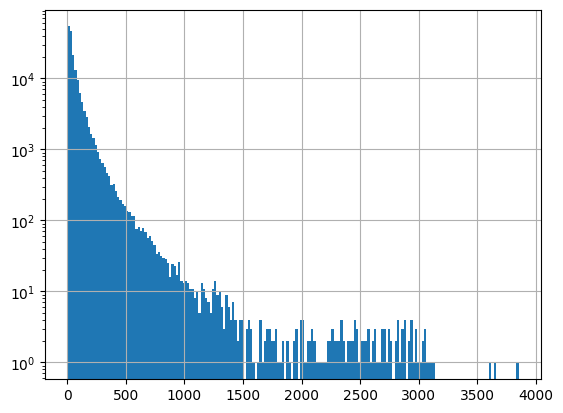

In [98]:
df_csv[df_csv['n_tokens'] < 4000]['n_tokens'].hist(bins=200, log=True)

<Axes: >

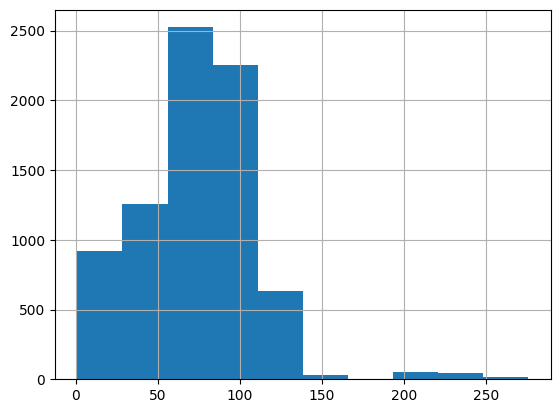

In [ ]:
df_sdk.n_tokens.hist()